<a href="https://colab.research.google.com/github/Servat0r/Robotics-Project/blob/master/DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Augmentation
We start with a simple `Data Augmentation` technique consisting in horizontally flipping the image.

We implement the following:
* Brightness change
* Saturation change
* Inversion (whole image)
* Gaussian Noise
* Salt & Pepper
* Horizontal Flip

#### Offline Data Augmentation

In [ ]:
def apply_brightness_change(images, tip_pos, delta):
  new_images = tf.image.adjust_brightness(images, delta).numpy()
  return new_images, tip_pos.copy()

def apply_saturation_change(images, tip_pos, saturation_factor):
  new_images = tf.image.adjust_saturation(images, saturation_factor).numpy()
  return new_images, tip_pos.copy()

def apply_inversion(images, tip_pos):
  new_images = 1.0 - images
  return new_images, tip_pos.copy()

def apply_gaussian_noise(images, tip_pos, sigma=0.1):
  new_images = images.copy() + (sigma ** 2) * np.random.randn(*images.shape)
  return new_images, tip_pos.copy()

def apply_horizontal_flip(images, tip_pos):
  flipped_images = np.flip(images, axis=2)
  flipped_tip_pos = tip_pos.copy()
  flipped_tip_pos[:, 1] = -flipped_tip_pos[:, 1]
  return flipped_images, flipped_tip_pos

def apply_salt_and_pepper(images, tip_pos, prob=0.1):
  '''
  Add salt and pepper noise to image
  :param prob: Probability of the noise
  '''
  new_images = np.zeros(images.shape,np.float32)
  thres = 1 - prob
  randoms = np.random.uniform(0., 1., size=images.shape).astype(np.float32)
  new_images = (randoms < prob) * 0. + (randoms > thres) * 1. + (prob <= randoms) * (randoms <= thres) * images
  return new_images, tip_pos.copy()

In [ ]:
def augment_dataset(images, tip_pos, **parameters):
  """
  Augments the dataset by applying specified augmentation functions to the images and tip positions.

  Parameters:
      images (numpy.ndarray): A numpy array of shape (num_images, height, width, channels) representing the original images.
      tip_pos (numpy.ndarray): A numpy array of shape (num_images, 3) representing the original tip positions.
      **parameters: Additional keyword arguments specifying the augmentation functions and their parameters.

  Returns:
      tuple: A tuple containing two elements:
          - augmented_images (numpy.ndarray): A numpy array of shape (num_augmented_images, height, width, channels) representing the augmented images.
          - augmented_tip_pos (numpy.ndarray): A numpy array of shape (num_augmented_images, 3) representing the augmented tip positions.

  """
  new_data = [images]
  new_labels = [tip_pos]
  for param_name, param_values in parameters.items():
    func = eval(param_name)
    new_images, new_pos = func(images, tip_pos, **param_values)
    new_data.append(new_images)
    new_labels.append(new_pos)
  return np.row_stack(new_data), np.row_stack(new_labels)

In [ ]:
def get_augmented_dataset(
    image_data_path='data/image/ws_0.5', motion_data_path='data/motion/ws_0.5.npz',
    resize=True, force_resize=True, target_size_perc=0.125, rescale_coordinates=1,
    target_size=None, **parameters
):
  """
  Returns the augmented dataset with the images and tip positions after applying specified augmentation functions.

  Parameters:
    image_data_path (str): Path to the directory containing the image data. Default is 'data/image/ws_0.5'.
    motion_data_path (str): Path to the motion data file. Default is 'data/motion/ws_0.5.npz'.
    resize (bool): Flag to enable resizing of the images. Default is True.
    force_resize (bool): Flag to force image resizing even if resized images already exist. Default is True.
    target_size_perc (float): Percentage of the target image size relative to the original size. Default is 0.125.
    rescale_coordinates (float): Scaling factor for the tip position coordinates. Default is 1.
    target_size (tuple): Tuple specifying the target height and width of the images. Default is None.
    **parameters: Additional keyword arguments specifying the augmentation functions and their parameters.

  Returns:
    tuple: A tuple containing two elements:
      - augmented_images (numpy.ndarray): A numpy array of shape (num_augmented_images, height, width, channels) representing the augmented images.
      - augmented_tip_pos (numpy.ndarray): A numpy array of shape (num_augmented_images, 3) representing the augmented tip positions.

  """
  images, tip_pos = get_dataset(
      image_data_path, motion_data_path, resize, force_resize, target_size_perc,
      rescale_coordinates, target_size
  )
  return augment_dataset(images, tip_pos, **parameters)

In [ ]:
# An example configuration for augmenting dataset
augmentation_configuration = {
    'apply_brightness_change': {'delta': 0.2},
    'apply_saturation_change': {'saturation_factor': 1},
    'apply_inversion': {},
    'apply_gaussian_noise': {'sigma': 0.1},
    'apply_salt_and_pepper': {'prob': 0.1}
}

In [ ]:
images, tip_pos = get_augmented_dataset(
    force_resize=False, rescale_coordinates=100, **augmentation_configuration,
)

In [ ]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)
print(f"Total length: {len(images)}", f"Training Set: {len(train_images)}", f"Validation Set: {len(eval_images)}", sep='\n')

Total length: 3078
Training Set: 2462
Validation Set: 616


In [ ]:
del images

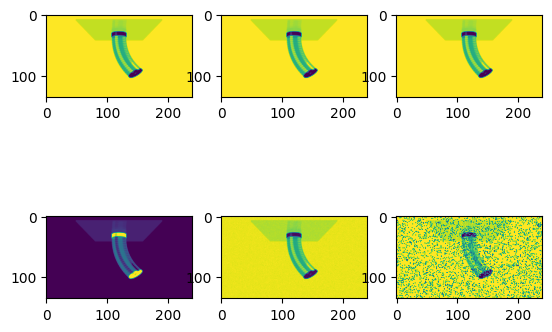

In [ ]:
# Plot examples
IDX = 12
LEN = 513
fig, ax = plt.subplots(2, 3)
plt.imshow(images[0, :, :, 1])
ax[0, 0].imshow(images[IDX, :, :, 1])
ax[0, 1].imshow(images[IDX+LEN, :, :, 1])
ax[0, 2].imshow(images[IDX+2*LEN, :, :, 1])
ax[1, 0].imshow(images[IDX+3*LEN, :, :, 1])
ax[1, 1].imshow(images[IDX+4*LEN, :, :, 1])
ax[1, 2].imshow(images[IDX+5*LEN, :, :, 1])

#### Online Data Augmentation